In [47]:
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.datasets import QM9, TUDataset, ZINC, Planetoid, Amazon, Coauthor, CitationFull
from torch_geometric.loader import DataLoader
from ogb.nodeproppred import PygNodePropPredDataset
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:
# 분위수 정보를 노드 특징에 포함 : 분위수 값 자체가 학습을 안정적으로 유도할 수 있도록 추가
# 분위수 정보 확장을 위한 데이터 변환
# 분위수 정보를 추가하여 GNN이 입력 특성에서 분위수를 학습 가능하도록 변경
# 값의 스케일링을 조정(12배 확대)하여 학습 안정성을 증가(Sigmoid 영역 내 활용)
# expand()를 사용하여 차원 유지
# tau는 분위수 이로 기본적으로 0~1 사이의 값이다.
# 하지만 딥러닝 모델은 일반적으로 입력값이 너무 작거나 큰 경우, 학습이 어려워지는 문제가 발생
#  0~1 범위의 값은 매우 작기 때문에 신경망의 활성화 함수(예: ReLU, tanh)에서 거의 변화를 일으키지 않을 수도 있습니다.
# 많은 머신러닝 모델(특히 신경망)은 입력 특징이 평균 0, 적절한 분산을 가지면 학습이 잘 됨.
# 표준 정규분포(평균 0, 표준편차 1)의 경우 ±3σ 구간(약 99.7%의 데이터)은 대략 -3 ~ 3 범위에 있음.
# 12는 일반적인 딥러닝 모델이 잘 학습하는 값의 범위(-6 ~ 6)를 만들기 위한 경험적인 값으로 보입니다.

# GCN 구조로 설계
# 여러 GNN 구조 중 GCN이 실험적으로 예측 안정성이 더 높은 경우가 많음
# GNN 기반 분위수 예측 모델
# 이 모델은 그래프 신경망(GNN) 중 하나인 GCN (Graph Convolutional Network) 기반으로, 특정 분위수(Quantile) 값을 예측하는 모델입니다. 
# 즉, 각 노드의 값을 "여러 분위수"로 예측할 수 있도록 설계된 그래프 신경망입니다.

# Coverage 조정 메커니즘 추가 : Coverage 보장이 부족할 경우 신뢰 구간을 자동 조정
# Coverage 보장을 위한 동적 분위수 조정 (DQA)
# Coverage가 부족하면 신뢰 구간을 넓히고, Coverage가 과하면 구간을 줄이는 방식으로 업데이트

# 분위수 손실 함수 (Coverage + PIW 최적화 포함)
# PIW 최적화 추가 : 신뢰 구간 폭을 줄이는 손실항을 추가하여 최적화

In [78]:
def augment_features(x, tau, scale_factor=12):
    """
    분위수 값을 학습 데이터에 추가하여 GNN이 학습할 수 있도록 변환하는 함수.
    
    Args:
        x (torch.Tensor): 원래 입력 특징값 (batch_size, feature_dim)
        tau (torch.Tensor): 분위수 값 (batch_size, 1)
        scale_factor (float): 분위수 값의 변환을 조절하는 스케일링 계수 (기본값: 12)
        
    Returns:
        torch.Tensor: 변환된 입력 특징값 (batch_size, feature_dim + 1)
    """
    tau = tau.view(-1, 1)  # tau를 (batch_size, 1) 형태로 변환
    tau_transformed = (tau - 0.5) * scale_factor  # 분위수 값 변환 (값의 범위를 조절하여 학습 안정성 증가)
    return torch.cat((x, tau_transformed.expand(x.size(0), -1)), dim=1)

class GCNQuantile(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCNQuantile, self).__init__()
        self.conv1 = GCNConv(in_channels + 1, hidden_channels)  # 분위수 값을 포함한 입력
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, 1) # 단일 분위수 학습을 위한 출력층

    def forward(self, x, edge_index, tau):
        x = augment_features(x, tau)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x
        
class QuantileLoss(nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()

    def forward(self, y_pred, y_true, tau):
        diff = y_true - y_pred  # 예측과 실제 값의 차이
        loss = torch.where(diff > 0, tau * diff, (1 - tau) * -diff)
        return torch.mean(loss)
    
def train_gqnn(model, optimizer, loss_fn, train_loader,
               train_mode="single", tau_low=0.05, tau_high=0.95, num_epochs=10000):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for data in train_loader:
            optimizer.zero_grad()
            
            if train_mode == "all":
                taus_low = torch.rand(data.x.size(0), 1) * (tau_low - 0.01) + 0.01  # 1% 이상
                taus_high = torch.rand(data.x.size(0), 1) * (tau_high - 0.01) + 0.01  # 99% 이하
            else:
                taus_low = torch.full((data.x.size(0), 1), tau_low)
                taus_high = torch.full((data.x.size(0), 1), tau_high)
            
            y_low_pred = model(data.x, data.edge_index, taus_low)
            y_high_pred = model(data.x, data.edge_index, taus_high)
            
            loss_low = loss_fn(y_low_pred, data.y.view(-1, 1), taus_low)
            loss_high = loss_fn(y_high_pred, data.y.view(-1, 1), taus_high)
            
            loss = loss_low + loss_high
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader):.4f}")

def test_gqnn(model, test_loader):
    model.eval()
    y_true_lst, y_low_lst, y_high_lst = [], [], []
    
    with torch.no_grad():
        for data in test_loader:
            tau_low = torch.full((data.x.size(0), 1), 0.05)
            tau_high = torch.full((data.x.size(0), 1), 0.95)
            
            y_low_pred = model(data.x, data.edge_index, tau_low)
            y_high_pred = model(data.x, data.edge_index, tau_high)
            
            y_true_lst.append(data.y.view(-1, 1))
            y_low_lst.append(y_low_pred)
            y_high_lst.append(y_high_pred)
            
    y_true = torch.cat(y_true_lst, dim=0).cpu().numpy()
    y_low = torch.cat(y_low_lst, dim=0).cpu().numpy()
    y_high = torch.cat(y_high_lst, dim=0).cpu().numpy()
    
    return y_true, y_low, y_high

def evaluate_coverage(y_true, y_low, y_high):
    return ((y_true >= y_low) & (y_true <= y_high)).float().mean().item()

In [79]:
# 가상 데이터 생성 함수
def generate_synthetic_graph(num_nodes=1000, num_edges=3000, num_node_features=5):
    edge_index = torch.randint(0, num_nodes, (2, num_edges))  # 무작위 엣지 연결
    x = torch.randn((num_nodes, num_node_features))  # 노드 특징값
    y = torch.randn((num_nodes, 1))  # 노드 회귀 타겟값
    return Data(x=x, edge_index=edge_index, y=y)

# 가상 데이터셋 생성
dataset = [generate_synthetic_graph() for _ in range(50)]

# 데이터셋을 학습 및 테스트 세트로 분할
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [80]:
# 모델 및 학습 설정
in_channels = dataset[0].x.shape[1]
hidden_channels = 64
learning_rate = 0.005
num_epochs = 5000

model = GCNQuantile(in_channels, hidden_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = QuantileLoss()

train_gqnn(model, optimizer, loss_fn, train_loader, num_epochs=num_epochs)

y_true, y_low, y_high = test_gqnn(model, test_loader)
coverage = evaluate_coverage(torch.tensor(y_true), torch.tensor(y_low), torch.tensor(y_high))
print(f"Coverage: {coverage:.4f}")

Epoch: 0, Loss: 0.4604
Epoch: 1000, Loss: 0.2047
Epoch: 2000, Loss: 0.2006
Epoch: 3000, Loss: 0.1989
Epoch: 4000, Loss: 0.1995
Coverage: 0.8779


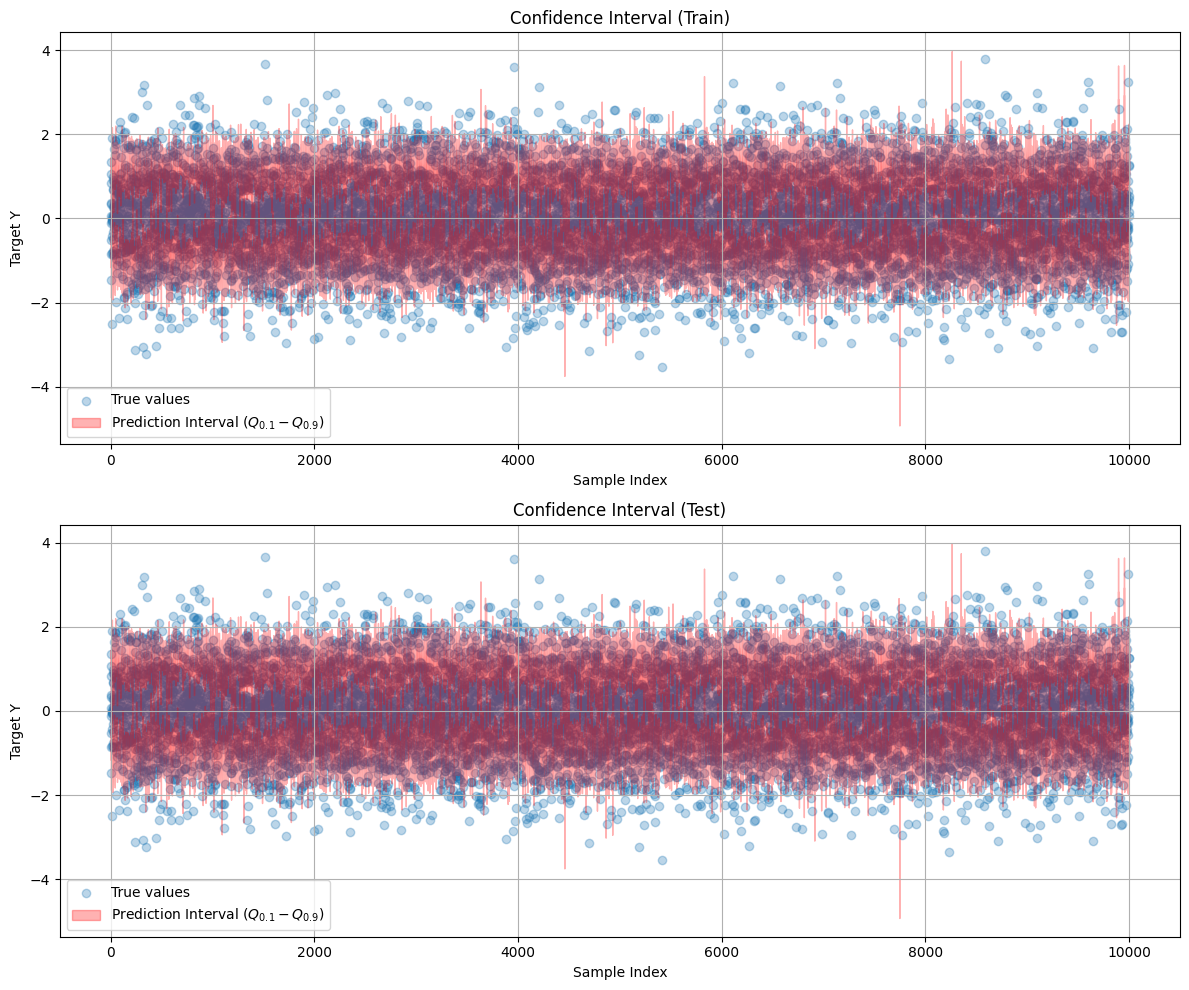

In [77]:
# 데이터 정렬 (샘플 인덱스 유지)
sorted_indices_train = np.argsort(y_true.flatten())
sorted_y_train = y_true[sorted_indices_train].flatten()
sorted_y_low_train = y_low[sorted_indices_train].flatten()
sorted_y_high_train = y_high[sorted_indices_train].flatten()

sorted_indices_test = np.argsort(y_true.flatten())
sorted_y_test = y_true[sorted_indices_test].flatten()
sorted_y_low_test = y_low[sorted_indices_test].flatten()
sorted_y_high_test = y_high[sorted_indices_test].flatten()

# 원래 샘플 순서 유지
sample_indices_train = np.arange(len(y_true))  # 학습 샘플 인덱스
sample_indices_test = np.arange(len(y_true))  # 테스트 샘플 인덱스

# 서브플롯 설정
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# 🔹 학습 데이터 시각화 (왼쪽 그래프)
ax[0].set_title("Confidence Interval (Train)")
ax[0].scatter(sample_indices_train, y_true.flatten(), alpha=0.3, label="True values")
ax[0].fill_between(sample_indices_train, y_low.flatten(), y_high.flatten(),
                   color='red', alpha=0.3, label="Prediction Interval ($Q_{0.1} - Q_{0.9}$)")
# ax[0].plot(sample_indices_train, (y_low.flatten() + y_high.flatten()) / 2, 
#            color="blue", linewidth=2, label="Predicted Mean ($Q_{0.5}$)")
ax[0].set_xlabel("Sample Index")
ax[0].set_ylabel("Target Y")
ax[0].legend()
ax[0].grid(True)

# 🔹 테스트 데이터 시각화 (오른쪽 그래프)
ax[1].set_title("Confidence Interval (Test)")
ax[1].scatter(sample_indices_test, y_true.flatten(), alpha=0.3, label="True values")
ax[1].fill_between(sample_indices_test, y_low.flatten(), y_high.flatten(),
                   color='red', alpha=0.3, label="Prediction Interval ($Q_{0.1} - Q_{0.9}$)")
# ax[1].plot(sample_indices_test, (y_low.flatten() + y_high.flatten()) / 2, 
#            color="blue", linewidth=2, label="Predicted Mean ($Q_{0.5}$)")
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel("Target Y")
ax[1].legend()
ax[1].grid(True)

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()


In [81]:
def coverage_loss(y_true, y_low, y_high, target_coverage=0.9):
    """
    목표 Coverage를 유지하기 위한 손실 함수.
    """
    coverage_exp = ((y_true >= y_low) & (y_true <= y_high)).float().mean()
    return (coverage_exp - target_coverage) ** 2

def piw_loss(y_low, y_high):
    """
    신뢰 구간 폭(PIW)을 최소화하는 손실 함수.
    """
    return torch.mean(y_high - y_low)  # 구간 폭의 평균을 최소화

def dynamic_quantile_adjustment(q_low, q_high, coverage_exp, coverage_target, learning_rate=0.01):
    """
    실제 Coverage가 목표 Coverage에 맞도록 분위수를 동적으로 조정하는 함수.
    """
    coverage_error = coverage_target - coverage_exp  # 목표 Coverage와 실제 Coverage 차이 계산
    q_low = q_low - learning_rate * coverage_error   # Coverage 부족 시 하한값 조정
    q_high = q_high + learning_rate * coverage_error # Coverage 부족 시 상한값 증가
    return q_low, q_high





def total_loss(y_true, y_preds, edge_index, quantiles, target_coverage=0.9, edge_weight=0.1, piw_weight=0.1, coverage_weight=1.0):
    """
    최종 손실 함수:
    - Quantile Loss (기본 분위수 손실)
    - Graph Regularization (이웃 노드 간 Smoothness 유지)
    - Coverage Loss (Coverage 보장)
    - PIW Loss (신뢰 구간 폭 최적화)
    """
    y_low, y_mid, y_high = y_preds  # 예측된 분위수 값 분리

    # 분위수 손실 (Quantile Loss)
    loss_q = sum(QuantileLoss()(y_pred, y_true, q) for y_pred, q in zip(y_preds, quantiles))

    # 그래프 정규화 (Graph Smoothness Loss)
    src, dst = edge_index
    loss_graph = edge_weight * torch.mean((y_preds[1][src] - y_preds[1][dst]) ** 2)

    # Coverage 보장 손실
    loss_coverage = coverage_weight * coverage_loss(y_true, y_low, y_high, target_coverage)

    # 신뢰 구간 폭(PIW) 최적화 손실
    loss_piw = piw_weight * piw_loss(y_low, y_high)

    return loss_q + loss_graph + loss_coverage + loss_piw

In [38]:
# 학습 함수
# Joint Quantile Learning 적용 (Multi-Quantile trainig)
# 여러 분위수를 동시에 학습하여 분위수 교차 문제 완화

def train_gqnn(data, device, target_coverage=0.9, q="all"):    
    model = GCNQuantile(in_channels=data.x.size(1), hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
    data = data.to(device)

    # 초기 분위수 설정 (q_low: 10%, q_high: 90%)
    q_low, q_high = 0.1, 0.9
    learning_rate = 0.01  # 분위수 조정 속도

    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # 여러 분위수를 동시에 학습 (Joint Quantile Training)
        if q == "all":
            taus = torch.rand(data.x.size(0), 1).to(device)
        else:
            taus = torch.full((data.x.size(0), 1), q, device=device)

        y_preds = model(data.x, data.edge_index, taus)
        y_low = y_preds[:, 0]  # 첫 번째 열이 10% 분위수
        y_mid = y_preds[:, 1]  # 두 번째 열이 50% 분위수
        y_high = y_preds[:, 2]  # 세 번째 열이 90% 분위수

        # 손실 계산 (Coverage + PIW 최적화 포함)
        loss = total_loss(data.y, y_preds, data.edge_index, model.quantiles)

        loss.backward()
        optimizer.step()

        # 현재 Coverage 측정
        coverage_exp = evaluate_coverage(data.y, y_low, y_high)

        # Coverage 보장: 분위수 업데이트
        q_low, q_high = dynamic_quantile_adjustment(q_low, q_high, coverage_exp, target_coverage, learning_rate)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Coverage = {coverage_exp:.4f}, PIW = {(y_high - y_low).mean().item():.4f}")

    return model

In [39]:
# 사용할 데이터셋 선택 (Cora, Citeseer, Pubmed)
dataset_name = "Cora"  # "Citeseer", "Pubmed", "Computers", "Photo" 등도 가능
dataset = Planetoid(root='/tmp/' + dataset_name, name=dataset_name, transform=T.NormalizeFeatures())

# 데이터셋 불러오기
data = dataset[0]
data.y = data.y.float().view(-1, 1)  # 타겟 값을 float형으로 변환 (회귀 수행 가능하도록 변경)

In [40]:
print(f"Dataset: {dataset_name}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features per node: {data.num_features}")
print(f"Number of classes: {dataset.num_classes}")  # 원래 분류 문제이므로 클래스 개수 출력

Dataset: Cora
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7


In [41]:
# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# 모델 학습 실행 (Coverage 보장 & 신뢰 구간 최적화 포함)
model = train_gqnn(data, device, q="all")

ValueError: too many values to unpack (expected 3)